In [1]:
import time
import os
import numpy as np
import math
import matplotlib.pyplot as plt

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
from tensorflow.keras import layers, models

tf.get_logger().setLevel('ERROR')

In [2]:
from sklearn.metrics import confusion_matrix
import pandas as pd

In [3]:
import tensorflow_datasets as tfds

/home/balazs/anaconda3/envs/jupy/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load data

Number classification task

In [48]:
# DATA_DIR = "./numbers/"
DATA_DIR = "../../../number_classification/train_data"
CHECKPOINT_PATH = "../models/"
BATCH_SIZE = None
IMG_HEIGHT = 28
IMG_WIDTH = 28
TRAIN_VAL_RATIO = 0.01

In [49]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=TRAIN_VAL_RATIO,
    subset="training",
    seed=123,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    color_mode='grayscale')

val_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=TRAIN_VAL_RATIO,
    subset="validation",
    seed=123,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    color_mode='grayscale')

Found 2191 files belonging to 10 classes.
Using 2170 files for training.
Found 2191 files belonging to 10 classes.
Using 21 files for validation.


# Load model

In [5]:
model = tf.keras.models.load_model('model_3.h5')

In [6]:
optimizer = tf.keras.optimizers.Adam(learning_rate=10e-5)
model.compile(optimizer=optimizer,
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                  metrics=['accuracy'])

# Image prediction

## Clear the folders of results

In [16]:
import datetime
from helper_functions import *
import cv2
from tqdm import tqdm

In [117]:
import os

# Define the parent directory
parent_dir = DATA_DIR
# Loop through numbers 0 to 9
for i in range(10):
    # Create a directory for each number
    dir_path = os.path.join(parent_dir, str(i))
    os.makedirs(dir_path, exist_ok=True)

In [68]:
DATA_DIR = './final_image/'

In [69]:
TRAIN_VAL_RATIO = 0.2

In [70]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=TRAIN_VAL_RATIO,
    subset="training",
    seed=123,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    color_mode='grayscale')

val_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=TRAIN_VAL_RATIO,
    subset="validation",
    seed=123,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    color_mode='grayscale')

Found 16 files belonging to 10 classes.
Using 13 files for training.
Found 16 files belonging to 10 classes.
Using 3 files for validation.


In [80]:
t_data,t_label = zip(*[(a.numpy(),b.numpy()) for a,b in iter(train_ds)])
val_data,val_label = zip(*[(a.numpy(),b.numpy()) for a,b in iter(val_ds)])
train_x = np.array(t_data, np.uint8)
train_y = np.array(t_label, np.int64)
val_x = np.array(val_data, np.uint8)
val_y = np.array(val_label, np.int64)



In [81]:
con_x = np.concatenate((train_x, val_x), axis=0)
con_y = np.concatenate((train_y, val_y), axis=0)

In [82]:
images, labels = con_x, con_y

In [87]:
prediction = model.predict(images)
model.evaluate(images,labels)

all_class_predictions = prediction
predictions = np.argmax(prediction, axis=1)
print(predictions.shape, type(prediction))

wrongs = np.where(np.equal(predictions, labels) == True)[0]
print(wrongs)
wrongs = wrongs[[6,5,2,4,3,0,1,11]]

1/1 [==============================] - 0s 19ms/step - loss: 0.0245 - accuracy: 1.0000
(16,) <class 'numpy.ndarray'>
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]


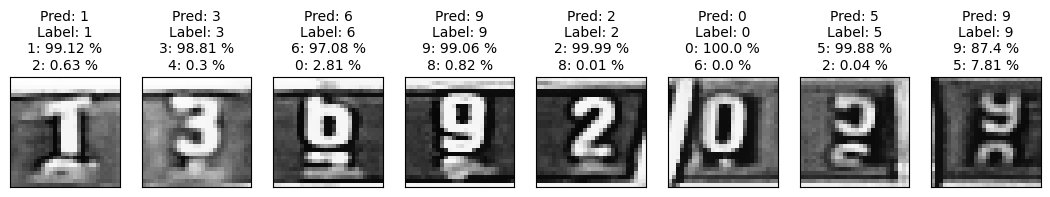

In [88]:
tup = np.asarray(list(zip(all_class_predictions, predictions, labels, images)), dtype=object)
tup = tup[wrongs]

dim = math.ceil(math.sqrt(len(tup)))
rows = 1
cols = dim * dim
fig = plt.figure(figsize=[15, 18])

for i, (all_class_prediction, prediction, label, img) in enumerate(tup): 
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    ax = plt.subplot(rows, cols, (i + 1))
    # ax.get_yaxis().set_visible(False)
    # ax.get_xaxis().set_visible(False)
    # ax.get_xlabel().set_visible_visible(True)
    # ax.set_xlabel()
    # disabling xticks by Setting xticks to an empty list
    plt.xticks([]) 

    # disabling yticks by setting yticks to an empty list
    plt.yticks([]) 
    plt.imshow(img/255.)
    # plt.axis('off')
    plt.title("Pred: " + str(prediction) + "\n" + "Label: " + str(label) + "\n" +
             str(np.argsort(all_class_prediction)[-1]) + ": " +
             str(round(sorted(all_class_prediction * 100)[-1], 2)) + " %" + "\n" + 
             str(np.argsort(all_class_prediction)[-2]) + ": " +
             str(round(sorted(all_class_prediction * 100)[-2], 2))  + " %", fontsize=10)
    # print(softmax(all_class_prediction))
    # print(str(round(np.max(all_class_prediction) * 100, 2)) + " %")
    # plt.xlabel("Pred: " + str(prediction) + " " + "Label: " + str(label), fontsize=8)
plt.show()

In [79]:
history = model.fit(
    con_x, con_y,
    validation_data=(con_x, con_y),
    epochs=1,
    batch_size=128,
    shuffle=True
    # callbacks=[model_checkpoint_callback]
)

1/1 [==============================] - 0s 67ms/step - loss: 0.1719 - accuracy: 0.9375 - val_loss: 0.0245 - val_accuracy: 1.0000


## Load csv data

In [56]:
import datetime

In [57]:
# df = pd.read_csv('./result_2/result_images.csv', header=None)
df = pd.read_csv('./result_2/result_images.csv', header=None)

## Sort data by time 

In [58]:
df_sorted = df.sort_values(by=0)

## Selecting data by value

In [59]:
MIN_VAL = 13688876
MAX_VAL = 13800000
# MIN_VAL = 1
# MAX_VAL = 99999999

In [60]:
df_sorted = df_sorted[df_sorted[1] > MIN_VAL]
df_sorted = df_sorted[df_sorted[1] < MAX_VAL]

In [61]:
df_sorted[1] = df_sorted[1].apply(lambda x: x/1000.)

In [62]:
df_sorted.head(2)

,0,1
123,2022-11-03T19:46:39_304+02:00.jpg,13688.891
83,2022-11-03T19:51:39_158+02:00.jpg,13688.982


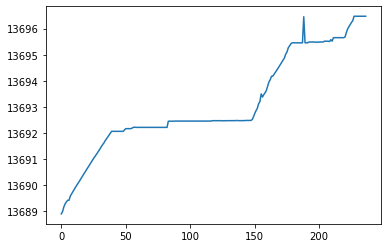

In [63]:
plt.plot(list(df_sorted[1]))
plt.show()

In [64]:
df_sorted

,0,1
123,2022-11-03T19:46:39_304+02:00.jpg,13688.891
83,2022-11-03T19:51:39_158+02:00.jpg,13688.982
174,2022-11-03T19:56:39_297+02:00.jpg,13689.163
223,2022-11-03T20:01:39_155+02:00.jpg,13689.280
249,2022-11-03T20:06:39_166+02:00.jpg,13689.356
...,...,...
179,2022-11-05T01:25:33_606+02:00.jpg,13696.475
230,2022-11-05T01:30:33_597+02:00.jpg,13696.475
137,2022-11-05T01:35:33_565+02:00.jpg,13696.475
49,2022-11-05T01:40:33_609+02:00.jpg,13696.475


## Creating timestamp from filenames

In [65]:
def timestamp_from_date(string) -> int:
    daymonth, time = string[:-10].split('T')
    year, month, day = daymonth.split('-')
    h, m ,sms = time.split(':')
    s, ms = sms.split('_')
    x_datetime = datetime.datetime(int(year),int(month),int(day),int(h),int(m),int(s),int(ms))
    return datetime.datetime.timestamp(x_datetime)

In [66]:
df_sorted["stamp"] = df_sorted[0].apply(timestamp_from_date)

In [67]:
df_sorted['datetime'] = df_sorted['stamp'].apply(lambda x: datetime.datetime.fromtimestamp(x))

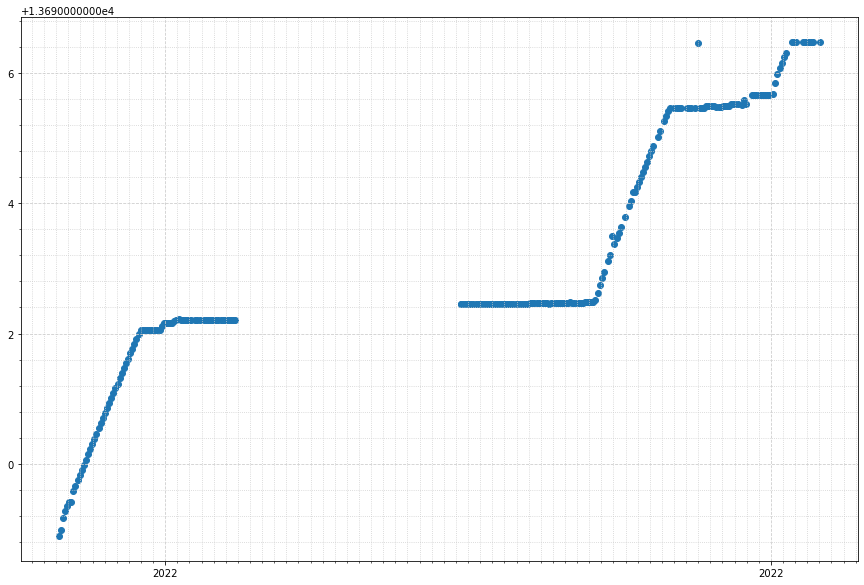

In [68]:
import matplotlib.pyplot as plt
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)

fig, ax = plt.subplots(figsize=(15, 10))

# Set axis ranges; by default this will put major ticks every 25.
# ax.set_xlim(0, 200)
# ax.set_ylim(0, 200)

# Change major ticks to show every 20.
ax.xaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_major_locator(MultipleLocator(2))

# # Change minor ticks to show every 5. (20/4 = 5)
ax.xaxis.set_minor_locator(AutoMinorLocator(50))
ax.yaxis.set_minor_locator(AutoMinorLocator(5))

# Turn grid on for both major and minor ticks and style minor slightly
# differently.
ax.grid(which='major', color='#CCCCCC', linestyle='--')
ax.grid(which='minor', color='#CCCCCC', linestyle=':')

ax.scatter(df_sorted["datetime"], df_sorted[1])

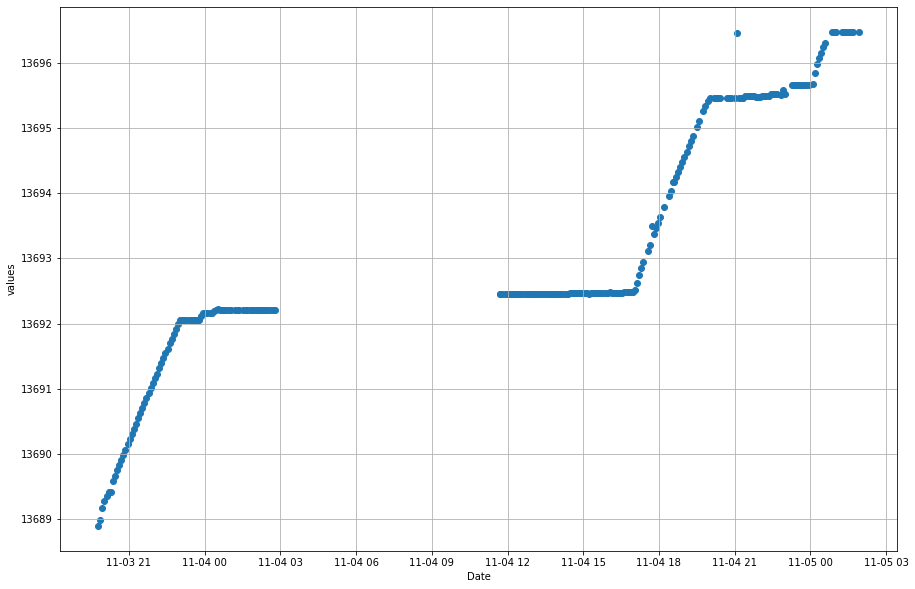

In [69]:
plt.figure(figsize=(15,10))
plt.scatter(df_sorted["datetime"], df_sorted[1])
# for line in daylines:
    # plt.axvline(x = daylines, color = 'gray', label = 'axvline - full height')
    # plt.text(10.1,0,'blah',rotation=90)
plt.grid()
plt.xlabel('Date')
plt.ylabel('values')
plt.show()

## Clean data

In [70]:
tu = list(zip(df_sorted[0],list(df_sorted[1])))

In [71]:
tu[0]

('2022-11-03T19:46:39_304+02:00.jpg', 13688.891)

In [72]:
clean = []
for i,t in enumerate(tu):
    if i == 0 or i == len(tu)-1:
        continue
    else:
        current = tu[i][1]
        left_nb = tu[i-1][1]
        right_nb = tu[i+1][1]
        
        diff_left = current- left_nb
        diff_right = right_nb - current
        if diff_left >= 0 and diff_left < 1 and \
            diff_right >= 0 and diff_right < 1:
            clean.append(t)
       

In [73]:
len(tu), len(clean)

(237, 208)

In [74]:
# list(set(tu) - set(clean))

In [75]:
filenames, results = zip(*clean)
print(len(results),"---",len(filenames),"---", results[0],"---", filenames[0])

208 --- 208 --- 13688.982 --- 2022-11-03T19:51:39_158+02:00.jpg


## Create new dataframe with extra columns (year,month,day etc.)

In [76]:
df_cleaned = pd.DataFrame()
df_cleaned["filenames"] = filenames
df_cleaned["measured_values"] = results

In [77]:
df_cleaned["stamp"] = df_cleaned["filenames"].apply(timestamp_from_date)
df_cleaned["year"] = df_cleaned["stamp"].apply(lambda x: datetime.datetime.fromtimestamp(x).year)
df_cleaned["month"] = df_cleaned["stamp"].apply(lambda x: datetime.datetime.fromtimestamp(x).month)
df_cleaned["day"] = df_cleaned["stamp"].apply(lambda x: datetime.datetime.fromtimestamp(x).day)

df_cleaned["hour"] = df_cleaned["stamp"].apply(lambda x: datetime.datetime.fromtimestamp(x).hour)
df_cleaned["minute"] = df_cleaned["stamp"].apply(lambda x: datetime.datetime.fromtimestamp(x).minute)
df_cleaned["second"] = df_cleaned["stamp"].apply(lambda x: datetime.datetime.fromtimestamp(x).second)

df_cleaned["ms"] = df_cleaned["stamp"].apply(lambda x: datetime.datetime.fromtimestamp(x).microsecond)

In [78]:
df_cleaned.head()

,filenames,measured_values,stamp,year,month,day,hour,minute,second,ms
0,2022-11-03T19:51:39_158+02:00.jpg,13688.982,1.667501e+09,2022,11,3,19,51,39,158
1,2022-11-03T19:56:39_297+02:00.jpg,13689.163,1.667502e+09,2022,11,3,19,56,39,297
2,2022-11-03T20:01:39_155+02:00.jpg,13689.280,1.667502e+09,2022,11,3,20,1,39,155
3,2022-11-03T20:06:39_166+02:00.jpg,13689.356,1.667502e+09,2022,11,3,20,6,39,166
4,2022-11-03T20:11:39_082+02:00.jpg,13689.417,1.667503e+09,2022,11,3,20,11,39,82


In [79]:
date1 = datetime.datetime(2022,10,24,0,0,0)
day1 = datetime.datetime.timestamp(date1)

date2 = datetime.datetime(2022,10,25,0,0,0)
day2 = datetime.datetime.timestamp(date2)

In [80]:
stamps = list(df_cleaned['stamp'])
start_date = datetime.datetime.fromtimestamp(stamps[0])
end_date = datetime.datetime.fromtimestamp(stamps[-1])

In [81]:
date_diff = end_date - start_date

In [82]:
start_date, end_date, date_diff

(datetime.datetime(2022, 11, 3, 19, 51, 39, 158),
 datetime.datetime(2022, 11, 5, 1, 40, 33, 609),
 datetime.timedelta(days=1, seconds=20934, microseconds=451))

In [83]:
date_diff.days

1

In [84]:
daylines = [datetime.datetime.timestamp(start_date)+i*86400 for i in range(date_diff.days + 3)]

In [85]:
daylines[0] - daylines[0] % 86400

1667433600.0

In [86]:
daylines = [stamp - stamp % 86400 for stamp in daylines]

In [87]:
dates = [datetime.datetime.fromtimestamp(stamp) for stamp in daylines]

In [88]:
dates

[datetime.datetime(2022, 11, 3, 1, 0),
 datetime.datetime(2022, 11, 4, 1, 0),
 datetime.datetime(2022, 11, 5, 1, 0),
 datetime.datetime(2022, 11, 6, 1, 0)]

In [89]:
now = datetime.datetime(1970,1,1,1,0,0,0)

In [90]:
datetime.datetime.timestamp(now)

0.0

In [91]:
datetime.date.fromtimestamp(0)

datetime.date(1970, 1, 1)

In [92]:
df_cleaned['datetime'] = df_cleaned['stamp'].apply(lambda x: datetime.datetime.fromtimestamp(x))
df_cleaned['date'] = df_cleaned['stamp'].apply(lambda x: datetime.date.fromtimestamp(x))

In [93]:
df_cleaned

,filenames,measured_values,stamp,year,month,day,hour,minute,second,ms,datetime,date
0,2022-11-03T19:51:39_158+02:00.jpg,13688.982,1.667501e+09,2022,11,3,19,51,39,158,2022-11-03 19:51:39.000158,2022-11-03
1,2022-11-03T19:56:39_297+02:00.jpg,13689.163,1.667502e+09,2022,11,3,19,56,39,297,2022-11-03 19:56:39.000297,2022-11-03
2,2022-11-03T20:01:39_155+02:00.jpg,13689.280,1.667502e+09,2022,11,3,20,1,39,155,2022-11-03 20:01:39.000155,2022-11-03
3,2022-11-03T20:06:39_166+02:00.jpg,13689.356,1.667502e+09,2022,11,3,20,6,39,166,2022-11-03 20:06:39.000166,2022-11-03
4,2022-11-03T20:11:39_082+02:00.jpg,13689.417,1.667503e+09,2022,11,3,20,11,39,82,2022-11-03 20:11:39.000082,2022-11-03
...,...,...,...,...,...,...,...,...,...,...,...,...
203,2022-11-05T01:20:33_516+02:00.jpg,13696.475,1.667608e+09,2022,11,5,1,20,33,516,2022-11-05 01:20:33.000516,2022-11-05
204,2022-11-05T01:25:33_606+02:00.jpg,13696.475,1.667608e+09,2022,11,5,1,25,33,606,2022-11-05 01:25:33.000606,2022-11-05
205,2022-11-05T01:30:33_597+02:00.jpg,13696.475,1.667608e+09,2022,11,5,1,30,33,597,2022-11-05 01:30:33.000597,2022-11-05
206,2022-11-05T01:35:33_565+02:00.jpg,13696.475,1.667609e+09,2022,11,5,1,35,33,565,2022-11-05 01:35:33.000565,2022-11-05


In [94]:
daylines

[1667433600.0, 1667520000.0, 1667606400.0, 1667692800.0]

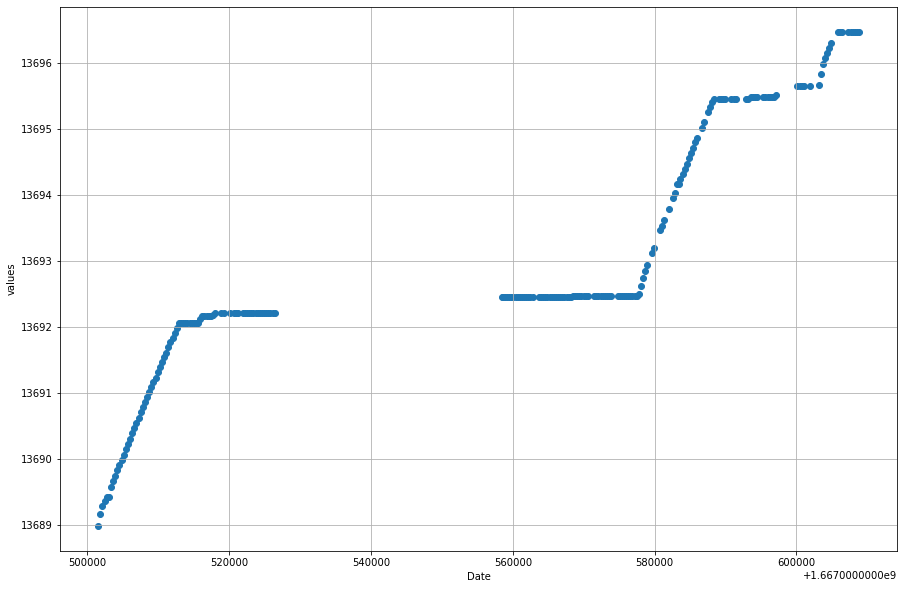

In [95]:
plt.figure(figsize=(15,10))
plt.scatter(df_cleaned['stamp'], df_cleaned['measured_values'])
# for line in daylines:
    # plt.axvline(x = daylines, color = 'gray', label = 'axvline - full height')
    # plt.text(10.1,0,'blah',rotation=90)
plt.grid()
plt.xlabel('Date')
plt.ylabel('values')
plt.show()

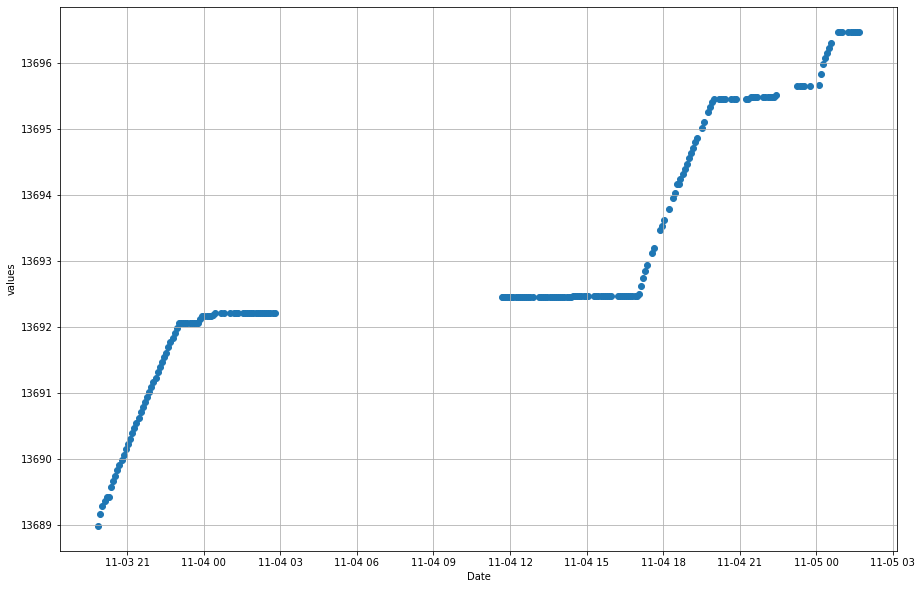

In [134]:
plt.figure(figsize=(15,10))
plt.scatter(df_cleaned['datetime'], df_cleaned['measured_values'])
# for line in daylines:
#     plt.axvline(x = line, color = 'gray', label = 'axvline - full height')
#     plt.text(10.1,0,'blah',rotation=90)
plt.grid()
plt.xlabel('Date')
plt.ylabel('values')
plt.show()

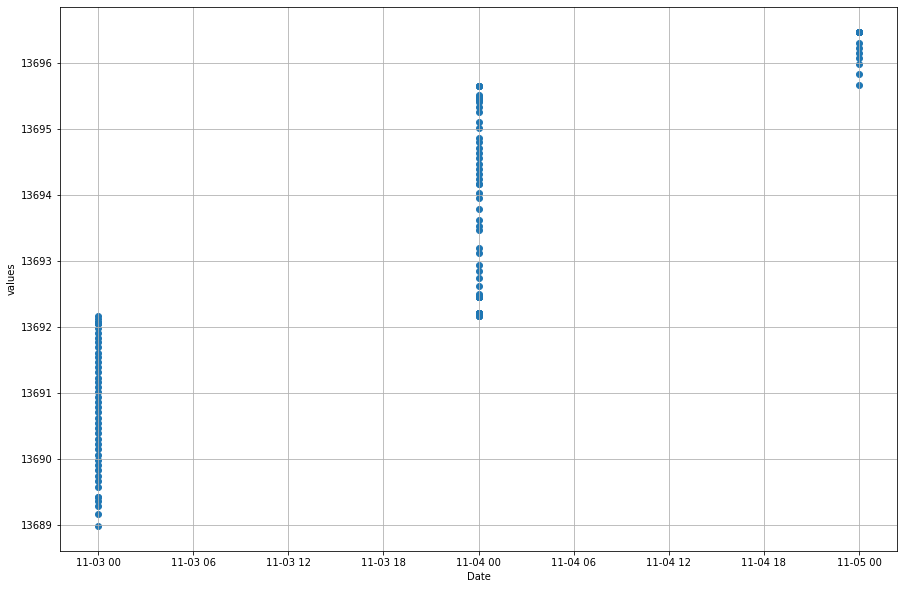

In [96]:
plt.figure(figsize=(15,10))
plt.scatter(df_cleaned['date'], df_cleaned['measured_values'])
# for line in daylines:
#     plt.axvline(x = line, color = 'gray', label = 'axvline - full height')
#     plt.text(10.1,0,'blah',rotation=90)
plt.grid()
plt.xlabel('Date')
plt.ylabel('values')
plt.show()

In [119]:
round(df_cleaned['stamp'].iloc[0])

1667501499

In [120]:
round(df_cleaned['stamp'].iloc[-1])

1667608833

In [146]:
df_cleaned['r_stamp'] = df_cleaned['stamp'].apply(lambda x: round(x))

In [147]:
df_cleaned.head()

,filenames,measured_values,stamp,year,month,day,hour,minute,second,ms,datetime,date,r_stamp
0,2022-11-03T19:51:39_158+02:00.jpg,13688.982,1.667501e+09,2022,11,3,19,51,39,158,2022-11-03 19:51:39.000158,2022-11-03,1667501499
1,2022-11-03T19:56:39_297+02:00.jpg,13689.163,1.667502e+09,2022,11,3,19,56,39,297,2022-11-03 19:56:39.000297,2022-11-03,1667501799
2,2022-11-03T20:01:39_155+02:00.jpg,13689.280,1.667502e+09,2022,11,3,20,1,39,155,2022-11-03 20:01:39.000155,2022-11-03,1667502099
3,2022-11-03T20:06:39_166+02:00.jpg,13689.356,1.667502e+09,2022,11,3,20,6,39,166,2022-11-03 20:06:39.000166,2022-11-03,1667502399
4,2022-11-03T20:11:39_082+02:00.jpg,13689.417,1.667503e+09,2022,11,3,20,11,39,82,2022-11-03 20:11:39.000082,2022-11-03,1667502699


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


13689.47


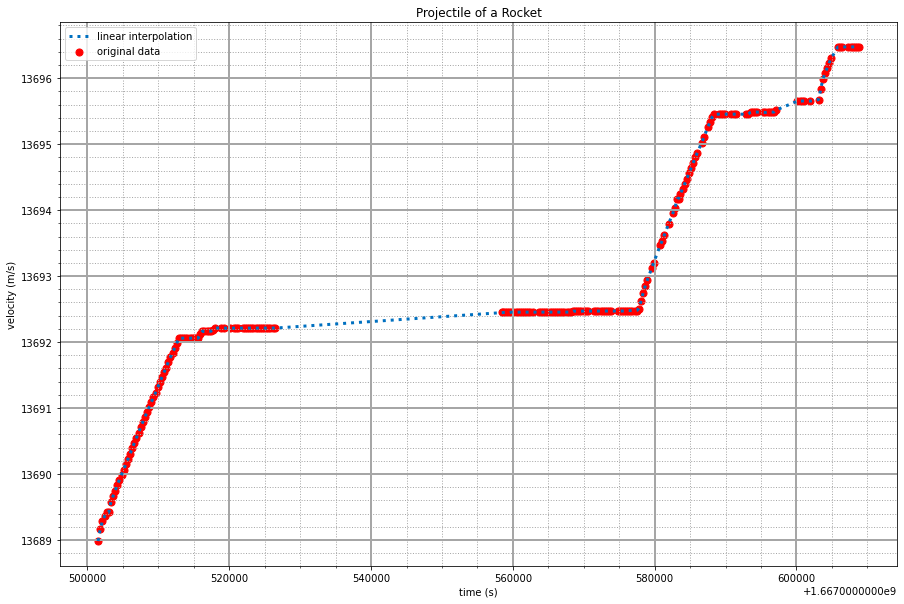

In [155]:
# Perquisites
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import scipy.interpolate
# Create Data
t = np.array(df_cleaned['r_stamp']) 
v = np.array(df_cleaned['measured_values'])

# start = np.array(df_cleaned['stamp'][0])
# end = np.array(df_cleaned['stamp'][-1])
start = round(df_cleaned['stamp'].iloc[0])
end = round(df_cleaned['stamp'].iloc[-1])

# t=np.array([0,10,15,20,22.5,30])
# v=np.array([0,227.04,362.78,517.35,602.97,901.67])
# Plot Data
plt.close('all')
plt.figure(1, figsize=(15,10))
plt.grid(axis='both',which='major',color=[166/255,166/255,166/255], linestyle='-', linewidth=2)
plt.minorticks_on()
plt.grid(axis='both',which='minor',color=[166/255,166/255,166/255], linestyle=':', linewidth=1)
plt.xlabel('time (s)')         
plt.ylabel('velocity (m/s)')        
plt.title('Projectile of a Rocket') 
plt.scatter(t,v,50,[255/255,0/255,0/255],label='original data')
# Create tnew Datapoints
tnew=np.arange(start=start,stop=end,step=100)
# Nearest Interpolation
# fvnearest=sp.interpolate.interp1d(t,v,kind='nearest')
# vnearest=fvnearest(tnew)
# Linear Interpolation
fvlinear=sp.interpolate.interp1d(t,v,kind='linear')
vlinear=fvlinear(tnew)
# fvlinear=sp.interpolate.interp1d(t,v,kind='quadratic')
# vlinear=fvlinear(tnew)
print(np.round(vlinear[16],3))
# Add tnew, vlinear line to existing plot
plt.plot(tnew,vlinear,color=[0/255,112/255,192/255], linestyle=':',label='linear interpolation', linewidth=3)
plt.legend(loc='upper left')

In [140]:
len(tnew)

108

In [141]:
fvlinear=sp.interpolate.interp1d(t,v,kind='linear')

In [201]:
df_cleaned['month'].unique()

array([11])

In [202]:
df_cleaned

,filenames,measured_values,stamp,year,month,day,hour,minute,second,ms,datetime,date
0,2022-11-03T17:57:37_774+02:00.jpg,13688.651,1.667495e+09,2022,11,3,17,57,37,774,2022-11-03 17:57:37.000774,2022-11-03
1,2022-11-03T18:01:39_113+02:00.jpg,13688.651,1.667495e+09,2022,11,3,18,1,39,113,2022-11-03 18:01:39.000113,2022-11-03
2,2022-11-03T18:06:39_184+02:00.jpg,13688.651,1.667495e+09,2022,11,3,18,6,39,184,2022-11-03 18:06:39.000184,2022-11-03
3,2022-11-03T18:11:39_174+02:00.jpg,13688.680,1.667495e+09,2022,11,3,18,11,39,174,2022-11-03 18:11:39.000174,2022-11-03
4,2022-11-03T18:16:39_165+02:00.jpg,13688.785,1.667496e+09,2022,11,3,18,16,39,165,2022-11-03 18:16:39.000165,2022-11-03
...,...,...,...,...,...,...,...,...,...,...,...,...
171,2022-11-04T20:55:33_194+02:00.jpg,13695.455,1.667592e+09,2022,11,4,20,55,33,194,2022-11-04 20:55:33.000194,2022-11-04
172,2022-11-04T21:00:33_216+02:00.jpg,13695.455,1.667592e+09,2022,11,4,21,0,33,216,2022-11-04 21:00:33.000216,2022-11-04
173,2022-11-04T21:10:33_127+02:00.jpg,13695.455,1.667593e+09,2022,11,4,21,10,33,127,2022-11-04 21:10:33.000127,2022-11-04
174,2022-11-04T21:15:33_214+02:00.jpg,13695.455,1.667593e+09,2022,11,4,21,15,33,214,2022-11-04 21:15:33.000214,2022-11-04


In [203]:
import sqlite3

In [204]:
!rm gasmeter_numbers.db

In [205]:
connection = sqlite3.connect("gasmeter_numbers.db")

In [206]:
cursor = connection.cursor()

In [207]:
# CREATE_TABLE = "CREATE TABLE measured_values ( \
#                 filename TEXT, \
#                 measured_values INTEGER, \
#                 timestamp FLOAT,  \
#                 year INTEGER, \
#                 month INTEGER, \
#                 day INTEGER, \
#                 hour INTEGER, \
#                 minute INTEGER, \
#                 second INTEGER)"

In [208]:
# cursor.execute(CREATE_TABLE)

In [209]:
# print(connection.total_changes)

In [210]:
# connection.tables

In [211]:
# con = sqlite3.connect('database.db')
# cursor = con.cursor()
# cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
# print(cursor.fetchall())

In [212]:
# INSERT = "INSERT INTO measured_values VALUES ()"

In [213]:
# for index, row in df_cleaned.iterrows():
#     print(index, row['year'], row['month'])
#     break

In [214]:
df_cleaned.to_sql(name="val", con=connection)

In [215]:
SELECT = "SELECT filenames, measured_values, stamp, year, month, day, hour, minute, second FROM val"
SELECT = "SELECT filenames, measured_values, stamp, year, month, day, hour, minute, second FROM val"
WHERE = " WHERE month = 11"
# WHERE = " WHERE hour < 12"
# WHERE = " WHERE hour < 12"
# WHERE = " WHERE hour < 12"
# WHERE = " WHERE hour < 12"
# WHERE = " WHERE hour < 12"


In [216]:
result = cursor.execute(SELECT + WHERE ).fetchall()

In [217]:
len(result)

176

In [218]:
df_query = pd.DataFrame(result, columns=list(df_cleaned.columns)[:-1])

ValueError: 11 columns passed, passed data had 9 columns

In [ ]:
df_query

In [ ]:
data = list(df_query['measured_values'])

In [ ]:
plt.plot(data)
plt.show()

In [ ]:
list(df_query.columns)

In [ ]:
 list(df_query['measured_values'])

In [ ]:
# date_start = (2022, 11 , 2)
# date_end = ((2022, 11 , 4))

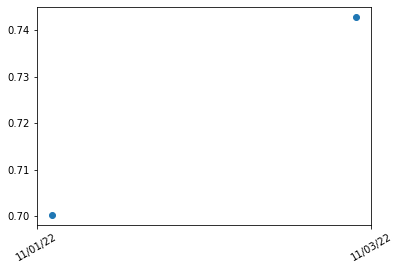

In [121]:
import matplotlib.pyplot as plt
from matplotlib.dates import (YEARLY, DateFormatter,
                              rrulewrapper, RRuleLocator, drange)
import numpy as np
import datetime

# Fixing random state for reproducibility
np.random.seed(19680801)


# tick every 5th easter
rule = rrulewrapper(YEARLY, byeaster=1, interval=5)
loc = RRuleLocator(rule)
formatter = DateFormatter('%m/%d/%y')
date1 = datetime.date(2022, 11, 2)
date2 = datetime.date(2022, 11, 4)
delta = datetime.timedelta(days=1)

dates = drange(date1, date2, delta)
s = np.random.rand(len(dates))  # make up some random y values


fig, ax = plt.subplots()
plt.plot_date(dates, s)
ax.xaxis.set_major_locator(loc)
ax.xaxis.set_major_formatter(formatter)
ax.xaxis.set_tick_params(rotation=30, labelsize=10)

plt.show()


In [137]:
np.array([datetime.datetime.fromtimestamp(stamp) for stamp in df_query['stamp']])

array([datetime.datetime(2022, 11, 2, 19, 5, 44, 127),
       datetime.datetime(2022, 11, 2, 19, 35, 37, 379),
       datetime.datetime(2022, 11, 2, 19, 53, 27, 666),
       datetime.datetime(2022, 11, 2, 21, 53, 19, 541),
       datetime.datetime(2022, 11, 2, 22, 23, 14, 835),
       datetime.datetime(2022, 11, 2, 23, 59, 57, 704),
       datetime.datetime(2022, 11, 3, 13, 32, 26, 765),
       datetime.datetime(2022, 11, 3, 13, 32, 42, 900),
       datetime.datetime(2022, 11, 3, 13, 32, 56, 477),
       datetime.datetime(2022, 11, 3, 13, 33, 12, 918),
       datetime.datetime(2022, 11, 3, 13, 33, 26, 485),
       datetime.datetime(2022, 11, 3, 13, 33, 41, 498),
       datetime.datetime(2022, 11, 3, 13, 33, 56, 481),
       datetime.datetime(2022, 11, 3, 13, 34, 12, 918),
       datetime.datetime(2022, 11, 3, 13, 34, 28, 11),
       datetime.datetime(2022, 11, 3, 13, 34, 41, 473),
       datetime.datetime(2022, 11, 3, 13, 34, 56, 458),
       datetime.datetime(2022, 11, 3, 13, 35, 11, 

In [136]:
datetime.datetime.fromtimestamp(df_query['stamp'][0])

datetime.datetime(2022, 11, 3, 18, 1, 39, 113)

Text(0, 0.5, 'values')

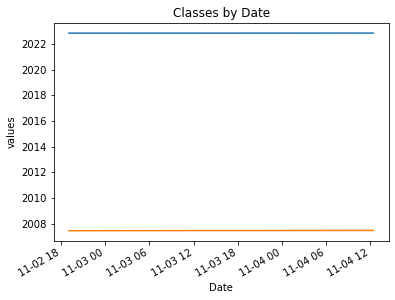

In [144]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import numpy as np
 
# Let say we have a dataframe of the days of
# the week and number of classes in each day of the upcoming week.
# Taking 7 days from 1-11-2021 to 7-11-2021
 
dataframe = pd.DataFrame({'date': np.array([datetime.datetime.fromtimestamp(stamp) for stamp in df_query['stamp']]),
                          'values': list(df_query['measured_values'])})
 
# To draw scatter time series plot of the given dataframe
# plt.plot_date(dataframe.date, dataframe.values)
plt.plot(dataframe.date, dataframe.values)
 
# rotating the x-axis tick labels at 30degree towards right
plt.xticks(rotation=30, ha='right')
 
# Giving title to the chart using plt.title
plt.title('Classes by Date')
 
# Providing x and y label to the chart
plt.xlabel('Date')
plt.ylabel('values')

In [142]:
dataframe

,date,values
0,2022-11-02 19:05:44.000127,13683.653
1,2022-11-02 19:35:37.000379,13683.656
2,2022-11-02 19:53:27.000666,13683.936
3,2022-11-02 21:53:19.000541,13686.016
4,2022-11-02 22:23:14.000835,13686.329
...,...,...
329,2022-11-04 12:02:56.000414,13692.453
330,2022-11-04 12:07:56.000437,13692.453
331,2022-11-04 12:12:56.000493,13692.453
332,2022-11-04 12:17:56.000332,13692.453


In [145]:
date = []
for time_val in value:
    date.append(datetime(*time.strptime(time_val, "%m/%d/%Y")[:3]))

fig, ax = plt.subplots()
ax.plot_date(date, value_list)
date_format = mdates.DateFormatter("%m/%d/%Y")
ax.xaxis.set_major_formatter(date_format)
ax.autoscale_view()
title_name = 'plot based on time'
ax.set_title(title_name)
y_label = 'values'
ax.set_ylabel(y_label)
ax.grid(True)

fig.autofmt_xdate()

plt.show()

NameError: name 'value' is not defined

In [303]:
math.exp(-0.1)

0.9048374180359595